In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

In [2]:
# helper function for visualize
from sklearn.manifold import TSNE

def dimension_reduce_TSNE(embeds):
    tsne2d = TSNE(n_components=2)
    embeds_2d = tsne2d.fit_transform(embeds)
    return embeds_2d

In [3]:
import os
# set location of testset prediction
EXP_BASE="exp_vector_2spk/diarize"
INFER_BASE=os.path.join(EXP_BASE, "infer/train-all-960_ns2_beta2_nu_3_20.dev-clean_ns2_beta2_500.vector_train_2spk_l2norm.avg68-83.vector_adapt_2spk_l2norm.avg40-50.vector_infer_2spk_l2norm_chunk500/npr/dev.2spk.8k")


In [4]:
# got kaldi format metadata for testset
from eend import kaldi_data
DATA_BASE="data/npr/dev.2spk.8k"

data_obj = kaldi_data.KaldiData(DATA_BASE)
# exist attribute for kaldi data object
# - segments (Dict[str, List[Dict]]): {recid: [{'utt': str, 'st': float, 'et': float}]}
# - utt2spk (Dict[str, str]): {uttid: 'str of all speakers id'}
# - wavs (Dict[str, str]): {recid: audio_file_name}
# - reco2dur (Dict[str, float]): {recid: duration_in_second}
# - spk2utt (Dict[str, List[str]]): {spkid: [uttid]}

In [5]:
def get_utt2rec(kaldi_data_obj):
    """Return mapping from uttid to recid."""
    utt2rec = {}
    for recid, segs in kaldi_data_obj.segments.items():
        for seg in segs:
            utt2rec[seg['utt']] = recid
    return utt2rec

In [6]:
utt2rec = get_utt2rec(data_obj)

In [7]:
# speakers might only appear once in a single record -> need spk2rec
def get_spk2rec(kaldi_data_obj):
    """Return mapping from spkid to list of recid."""
    utt2rec = get_utt2rec(kaldi_data_obj)
    spk2rec = {}
    for spkid, utts in kaldi_data_obj.spk2utt.items():
        spk2rec[spkid] = set()
        for utt in utts:
            recid = utt2rec[utt]
            spk2rec[spkid].add(recid)
    return spk2rec

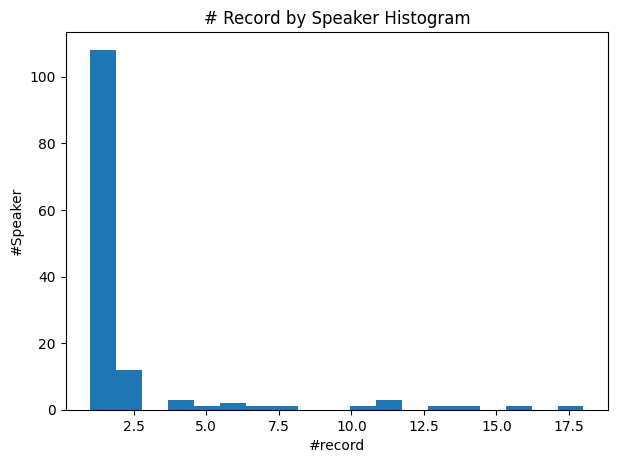

In [8]:
spk2rec = get_spk2rec(data_obj)
_spk_num_rec = [len(recs) for spk, recs in spk2rec.items()]

plt.hist(_spk_num_rec, bins=np.linspace(1, max(_spk_num_rec), 20))
plt.gca().set(title='# Record by Speaker Histogram', ylabel='#Speaker', xlabel='#record')
plt.show()

In [9]:
# testset may have record w/ empty label(transcription) or low label dur ratio -> need rec2labelratio
def get_record_labeled_ratio(kaldi_data_obj):
    records_labeled_ratio = {}
    for recid, utts in kaldi_data_obj.segments.items():
        labeled_dur = sum([utt['et'] - utt['st'] for utt in utts])
        rec_dur = kaldi_data_obj.reco2dur[recid]
        labeled_ratio = labeled_dur / rec_dur
        if labeled_ratio > 1.0:
            raise ValueError(f"Illegal label ratio: {labeled_ratio}")
        records_labeled_ratio[recid] = labeled_ratio
    return records_labeled_ratio

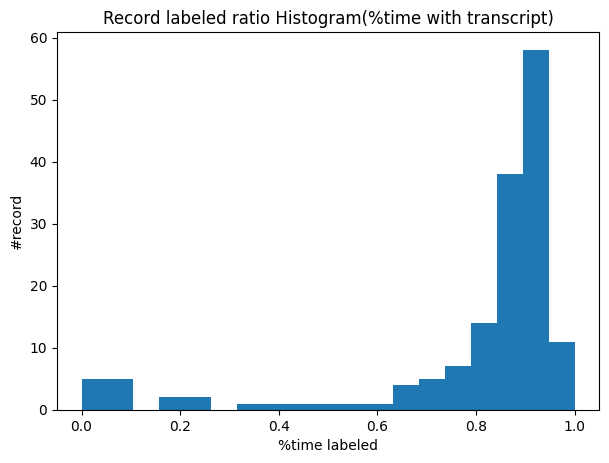

In [10]:
records_labeled_ratio = get_record_labeled_ratio(data_obj)

plt.hist([r for r in records_labeled_ratio.values()], bins=np.linspace(0, 1, 20))
plt.gca().set(title='Record labeled ratio Histogram(%time with transcript)', ylabel='#record', xlabel='%time labeled')
plt.show()

In [11]:
# plot :
# - record label ratio histogram: filter by label ratio
# - number of record appeared for different speaker: filter by speaker apperance
print(f"number of record: {len(records_labeled_ratio)}")
rids_labeled = [rid for rid, ratio in records_labeled_ratio.items() if ratio > 0.8]
print(f"number of record labeled: {len(rids_labeled)}")

number of record: 157
number of record labeled: 120


In [12]:
print(f"number of speaker: {len(spk2rec)}, total record {len(set([rec for recs in spk2rec.values() for rec in recs]))}")
spk2rec_gt1 = {spk: recs for spk, recs in spk2rec.items() if len(recs) > 1}
rids_with_multi_rec_spk = {rec for recs in spk2rec_gt1.values() for rec in recs}
print(f"number of speaker within multiple record: {len(spk2rec_gt1)}, correspond record {len(rids_with_multi_rec_spk)}")

number of speaker: 136, total record 157
number of speaker within multiple record: 28, correspond record 149


In [13]:
rids_labeled_with_multi_rec_spk = set(rids_labeled) & rids_with_multi_rec_spk
print(f"number of record labeled while with multi_rec_spk: {len(rids_labeled_with_multi_rec_spk)}")

number of record labeled while with multi_rec_spk: 115


Since most of record labeled also contain multi_rec_spk, we think this subset of testset is a good start for plot predicted embedding as is:
 - clean(labeled)
 - good for analyse(multiple record per speaker)

## Load prediction for those record

In [14]:
from pathlib import Path
import h5py
filtered_rec_inf_path = [
    Path(os.path.join(INFER_BASE, f"{rec}.h5")) for rec in rids_labeled_with_multi_rec_spk
]
filtered_rec_inf = [h5py.File(f, 'r') for f in filtered_rec_inf_path]

print(f"number of record prediction loaded: {len(filtered_rec_inf)}")
print(f"First record prediction load: basename={filtered_rec_inf_path[0].name}, id={filtered_rec_inf_path[0].name.split('.')[0]}")

number of record prediction loaded: 115
First record prediction load: basename=6577627.h5, id=6577627


In [15]:
def convert_h5_to_numpy(h5_inf_obj):
    np_dict = {name: h5_inf_obj[name][:] for name in h5_inf_obj.keys()}
    return np_dict

In [16]:
filtered_rec_inf_np = [convert_h5_to_numpy(h5_obj) for h5_obj in filtered_rec_inf]

In [17]:
def rebuild_inf_in_chunk(inf_obj, is_h5=False):
    if is_h5:
        inf_obj = convert_h5_to_numpy(inf_obj)
    T_hat = inf_obj["T_hat"]
    out_spks = inf_obj["out_spks"]
    chunk_sizes = inf_obj["chunk_sizes"]  # list of n_frames
    _, n_spk = T_hat.shape  # (n_frames, n_spks)
    _, dim_spk = out_spks.shape  # (n_spks_of_all_chunk, n_dim)
    acc_chunk_sizes = np.cumsum(chunk_sizes)
    T_hat_chunk = np.split(T_hat, acc_chunk_sizes[:-1])  # [(n_frames, n_spks)]
    out_spk_chunk = out_spks.reshape((len(chunk_sizes), n_spk, dim_spk))  # (n_chunk, n_spks, n_dim)
    return T_hat_chunk, out_spk_chunk

In [18]:
print(f"T_hat shape before reshape: {filtered_rec_inf_np[0]['T_hat'].shape}")
print(f"out_spks shape before reshape: {filtered_rec_inf_np[0]['out_spks'].shape}")
print(f"chunk_sizes before reshape: {filtered_rec_inf_np[0]['chunk_sizes']}")

print(f"T_hat shape in chunk: {[arr.shape for arr in rebuild_inf_in_chunk(filtered_rec_inf_np[0])[0]]}")
print(f"out_spks shape in chunk: {rebuild_inf_in_chunk(filtered_rec_inf_np[0])[1].shape}")

T_hat shape before reshape: (2280, 2)
out_spks shape before reshape: (10, 256)
chunk_sizes before reshape: [500 500 500 500 280]
T_hat shape in chunk: [(500, 2), (500, 2), (500, 2), (500, 2), (280, 2)]
out_spks shape in chunk: (5, 2, 256)


In [19]:
# list of recid correspond to loaded record inference
filtered_rec_id = [_path.name.split('.')[0] for _path in filtered_rec_inf_path]

### Question:
- How to handle possible silent (among two returned) speaker in each chunk
    - precise: detect them using some metric and not include them in the plot
    - aggressively: only plot the first as it won't be silent
- How to align speaker between chunk
    - complex: align according to predict energy (same to paper) and labeled duration percentage from kaldi meta data
    - precise: no accurate way to do this

#### Level to plot to make
- 1. plot all embeddings (which may contain silent speaker that make the plot irrelevent)
- 2. plot top embedding per chunk by mean value of T_hat (50 sec chunk should have at least one speaker)
- 3. retrieve by label

Text(0.5, 1.0, 'All speaker embedding 2D visualize')

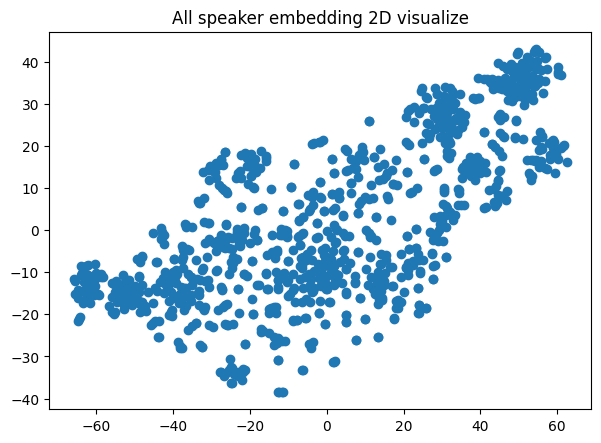

In [20]:
# 1. plot all embeddings
all_spk_embs = np.concatenate([_rec_inf['out_spks'] for _rec_inf in filtered_rec_inf_np])
all_spk_embs_2D = dimension_reduce_TSNE(all_spk_embs)
plt.scatter(all_spk_embs_2D[:, 0], all_spk_embs_2D[:, 1])
plt.title("All speaker embedding 2D visualize")

In [21]:
# 2. plot top embedding per chunk
def get_top_embedding(chunk_inf_obj):
    """Return top embedding per chunk, returned embedding shape as (n_chunk, n_dim)."""
    T_hat_chunks = chunk_inf_obj['T_hat']  # [(n_frames, n_spks)]
    out_spks_chunks = chunk_inf_obj['out_spks']  # (n_chunk, n_spks, n_dim)
    n_chunk, n_spks, n_dim = out_spks_chunks.shape
    selected_embs = np.empty((n_chunk, n_dim), dtype=out_spks_chunks.dtype)
    selected_id = []
    for i, (_T_hat, out_spks) in enumerate(zip(T_hat_chunks, out_spks_chunks)):
        _n_frames, _n_spks = _T_hat.shape
        _n_spks2, _n_dims = out_spks.shape
        assert _n_spks == _n_spks2, f"T_hat and out_spks shape not match: {_T_hat.shape}!={out_spks.shape}"
        T_hat_means = _T_hat.mean(axis=0)
        assert T_hat_means.shape != _n_spks, "Wrong operation!"
        top_spkid = np.argmax(T_hat_means)
        selected_id.append(top_spkid)
        selected_embs[i] = out_spks[top_spkid]
    assert len(selected_id) == len(selected_embs)
    return selected_embs

In [22]:
# rebuild prediction in chunk for each record
filtered_rec_inf_np_chunks = [dict(zip(['T_hat', 'out_spks'], rebuild_inf_in_chunk(_rec_inf))) for _rec_inf in filtered_rec_inf_np]
print(f"Chunk of first record: {[arr.shape for arr in filtered_rec_inf_np_chunks[0]['T_hat']]}")
print(f"Chunk of first record: {filtered_rec_inf_np_chunks[0]['out_spks'].shape}")
print(f"Top embedding of first record: {get_top_embedding(filtered_rec_inf_np_chunks[0]).shape}")

Chunk of first record: [(500, 2), (500, 2), (500, 2), (500, 2), (280, 2)]
Chunk of first record: (5, 2, 256)
Top embedding of first record: (5, 256)


filtered records have total 490 chunks.
extracted top embeddings shape: (490, 256)


Text(0.5, 1.0, 'Top speaker embedding per chunk 2D visualize')

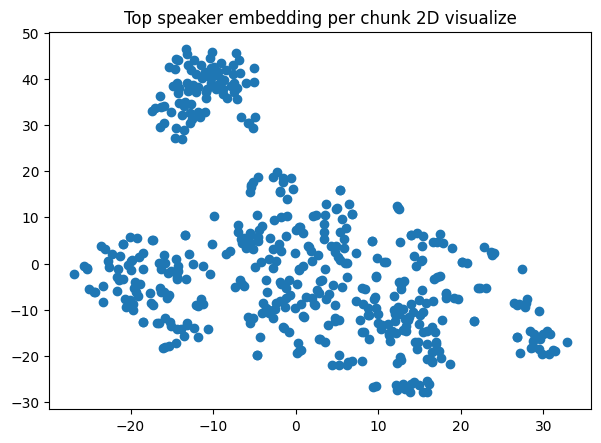

In [23]:
# get top embeddings for chunk of all record
rec_chunks_top_embs = [get_top_embedding(chunk_inf) for chunk_inf in filtered_rec_inf_np_chunks]
_total_chunk_num = sum([len(chunk_inf['T_hat']) for chunk_inf in filtered_rec_inf_np_chunks])
print(f"filtered records have total {_total_chunk_num} chunks.")
_chunks_top_embs_concat = np.concatenate(rec_chunks_top_embs)
print(f"extracted top embeddings shape: {_chunks_top_embs_concat.shape}")
_chunks_top_embs_concat_2D = dimension_reduce_TSNE(_chunks_top_embs_concat)
plt.scatter(_chunks_top_embs_concat_2D[:, 0], _chunks_top_embs_concat_2D[:, 1])
plt.title("Top speaker embedding per chunk 2D visualize")

In [ ]:
# retrieve label from kaldi metadata by chunk

In [24]:
print(f"chunk_sizes of first record: {filtered_rec_inf_np[0]['chunk_sizes']}")
print(f"first record id: {filtered_rec_id[0]}")
print(f"first record duration: {data_obj.reco2dur[filtered_rec_id[0]]}")

chunk_sizes of first record: [500 500 500 500 280]
first record id: 6577627
first record duration: 227.9706


In [25]:
import math

CHUNK_TIME = 50.0

def get_rec_spk(kaldi_data_obj, chunk_time=50.0):  #, threshold=0.05):
    """Return {rec: [{spk by chunk: dur}]} mapping.

    Args:
    kaldi_data_obj has flowing attr
    # - segments (Dict[str, List[Dict]]): {recid: [{'utt': str, 'st': float, 'et': float}]}
    # - utt2spk (Dict[str, str]): {uttid: 'str of all speakers id'}
    # - wavs (Dict[str, str]): {recid: audio_file_name}
    # - reco2dur (Dict[str, float]): {recid: duration_in_second}
    # - spk2utt (Dict[str, List[str]]): {spkid: [uttid]}
    chunk_time (float): elapsed time for each chunk
    threshold (float): percentage of chunk_time to consider labeled a speaker
    """
    rec2chunkspks = {}
    for recid, segs in kaldi_data_obj.segments.items():
        rec_dur = kaldi_data_obj.reco2dur[recid]
        num_chunk = math.ceil(rec_dur / chunk_time)
        current_rec_chunks_spkmap = [{} for _ in range(num_chunk)]
        for seg in segs:
            uttid = seg['utt']
            spkid = kaldi_data_obj.utt2spk[uttid]
            st_chunk_id = int(seg['st'] / chunk_time)
            et_chunk_id = int(seg['et'] / chunk_time)
            for _chunk_id in range(st_chunk_id, et_chunk_id+1):
                assert _chunk_id < len(current_rec_chunks_spkmap), f"IndexError: {_chunk_id} >= {num_chunk}[{seg['et']}, {et_chunk_id}]"
                start_chunk_time = chunk_time * _chunk_id
                end_chunk_time = chunk_time * (_chunk_id + 1)
                seg_chunk_start = max(start_chunk_time, seg['st'])
                seg_chunk_end = min(end_chunk_time, seg['et'])
                seg_chunk_dur = seg_chunk_end - seg_chunk_start
                curr_chunk_spkid_dur = current_rec_chunks_spkmap[_chunk_id].get(spkid, 0)
                current_rec_chunks_spkmap[_chunk_id][spkid] = curr_chunk_spkid_dur + seg_chunk_dur
        rec2chunkspks[recid] = current_rec_chunks_spkmap
    return rec2chunkspks

In [26]:
rec2chunkspks = get_rec_spk(data_obj)

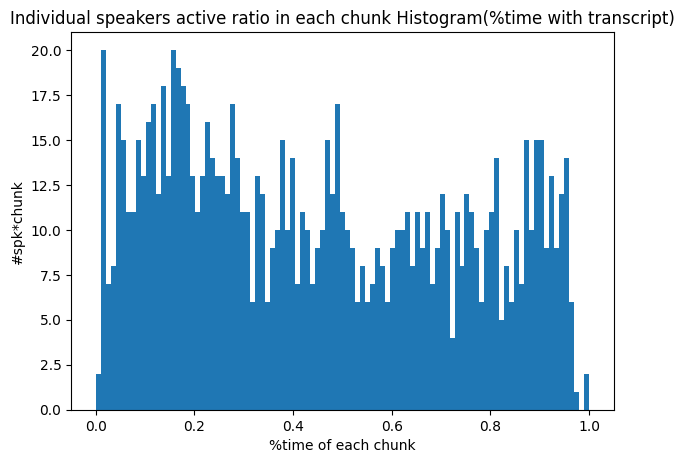

In [27]:
# show active ratio of utt seperated in each chunk
spks_active_ratio_in_each_chunk = [spk_dur/CHUNK_TIME for chunks_spks in rec2chunkspks.values() for chunk_spks in chunks_spks for spk_dur in chunk_spks.values()]

plt.hist(spks_active_ratio_in_each_chunk, bins=np.linspace(0, 1, 100))  # bin_size: 0.01 * 50 = 0.5sec
plt.gca().set(title='Individual speakers active ratio in each chunk Histogram(%time with transcript)', ylabel='#spk*chunk', xlabel='%time of each chunk')
plt.show()

#### plot embeddings that correspond to label?
Consider the diarization tag prediction: we consider a speaker is speaking at a specific frame if the value is above thereshold, therefore the value give us a confidence on if he is speaking at that frame. The more high value it have for each frames in the chunk(result in higher chunk mean value), the more time it should be considered as active.

By gathering the labeled speech duration for each chunk, we got a relative importance the mean value it should be predict. That been said, spk1 with 60% time labeled in kaldi meta data for a chunk should have a higher predicted mean value compare to spk2 which only has 20% for example.

Then the align between chunk can be conducted by label the speaker embedding with higher mean diarization value as the speaker with higher duration.

If the speaker is only active for a small portion of time throught out a chunk (say 5%*50sec=2.5sec), the mean T_hat value may be hard to tell and can be more as some statistical average like background noise. In order to avoid them bluring the potentiel cluster border, we can remove them from plot, this can be done by assert labeled duration or/and mean value.



In [28]:
# kaldi meta data: data_obj
# rec2chunkspks: {rec: [{spk: dur} * chunk]}
# predict: filtered_rec_inf_path
#   --load--> filtered_rec_inf --h5_to_np--> filtered_rec_inf_np --rebuild_chunk--> filtered_rec_inf_np_chunks: List[Dict[str, Any]]
#   --> filtered_rec_id: List[str]
#

# def update_list_dict(main_dict, dict2add):
#     final_dict = {**main_dict}
#     for k, v in dict2add.items():
#         if k not in final_dict:
#             final_dict[k] = v
#         else:
#             final_dict[k].extend(v)
#     return final_dict


def gather_emb_by_spk(recs_id, recs_inf_chunks, rec2chunkspks_map, threshold=None):
    emb_by_spk = {}
    num_skipped = 0
    assert len(recs_id) == len(recs_inf_chunks), "Records prediction not align to id"
    for rid, rec_inf_dict in zip(recs_id, recs_inf_chunks):
        rec_chunks = rec2chunkspks_map[rid]  # [{spk: dur} * chunk]
        T_hat_chunks = rec_inf_dict['T_hat']  # shape: [(n_frames, n_spks)]
        out_spk_chunks = rec_inf_dict['out_spks']  # shape: (n_chunk, n_spks, n_dim)
        n_chunk = len(rec_chunks)
        assert n_chunk == len(T_hat_chunks), "prediction mismatch rid for n_chunk"
        # emb_by_spk_chunk_cur = {}
        for chunk_i in range(n_chunk):
            rec_chunk = rec_chunks[chunk_i]  # {spk: dur}
            T_hat_chunk = T_hat_chunks[chunk_i]  # (n_frames, n_spks)
            out_spk_chunk = out_spk_chunks[chunk_i]  # shape: (n_spks, n_dim)
            means_T_hat = np.mean(T_hat_chunk, axis=0) # (n_spks)
            dest_mean_spk_ids = np.argsort(means_T_hat)[::-1]
            chunk_spk_emb_sorted = out_spk_chunk[dest_mean_spk_ids]  # embedding sorted by predicted mean value
            rec_chunk_sorted = sorted([(spk, dur) for spk, dur in rec_chunk.items()], key=lambda x: x[1], reverse=True)  # spk sorted by labeled duration
            for i, (spk, dur) in enumerate(rec_chunk_sorted):
                labeled_pct = dur / CHUNK_TIME
                chunk_spk_emb_i = chunk_spk_emb_sorted[i] # spk embedding with i-th great predicted mean
                if threshold is not None and labeled_pct < threshold:
                    # spk's labeled_pct too small to be noticable, skip it
                    num_skipped += len(rec_chunk_sorted) - i
                    break
                if spk not in emb_by_spk:
                    emb_by_spk[spk] = []
                emb_by_spk[spk].append(chunk_spk_emb_i)
        # emb_by_spk = update_list_dict(emb_by_spk, emb_by_spk_chunk_cur)
    print(f"Skipped {num_skipped} embeddings below threshold {threshold}")
    return emb_by_spk

emb_by_spk = gather_emb_by_spk(filtered_rec_id, filtered_rec_inf_np_chunks, rec2chunkspks)

Skipped 0 embeddings below threshold None


In [29]:
def combine_emb_with_spk(emb_by_spk_map):
    embs, label = [], []
    for spk, emb_list in emb_by_spk_map.items():
        num_emb = len(emb_list)
        embs.extend(emb_list)
        label.extend([spk for _ in range(num_emb)])
    embs_np = np.stack(embs)
    return embs_np, label

In [30]:
def plot2D_by_category(X_2d, Y, num2plot=None, with_legend=False):
    assert len(X_2d) == len(Y), f"label Y not match data X_2d in size: {len(Y)} != {len(X_2d)}"
    category_names = list(set(Y))
    print(f"Total {len(Y)} of {len(category_names)} category.")
    if num2plot is not None:
        category_names = category_names[:num2plot]
        print(f"only plot {len(category_names)} class")
    colors = [np.random.rand(3,) for i in category_names]
    plt.figure(figsize=(8, 8))
    for color, target_name in zip(colors, category_names):
        cluster_ids = [i for i, name in enumerate(Y) if name == target_name]
        plt.scatter(X_2d[cluster_ids, 0], X_2d[cluster_ids, 1], color=color, lw=2, label=target_name)
    plt.title("speaker audio embedding 2D visualize")
    if with_legend:
        plt.legend(loc='best')
    plt.show()

Total 857 of 102 category.


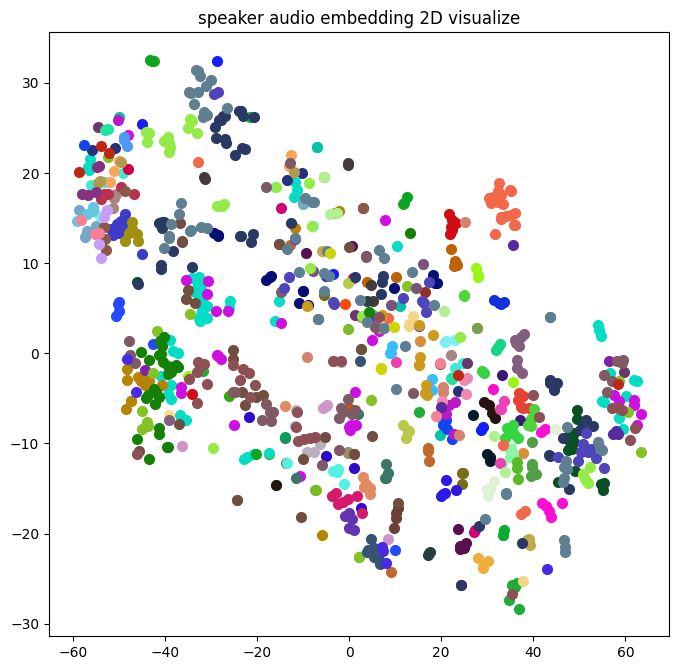

In [31]:
embs_np, embs_label = combine_emb_with_spk(emb_by_spk)
embs_np_2D = dimension_reduce_TSNE(embs_np)
plot2D_by_category(embs_np_2D, embs_label)

Total 857 of 102 category.
only plot 10 class


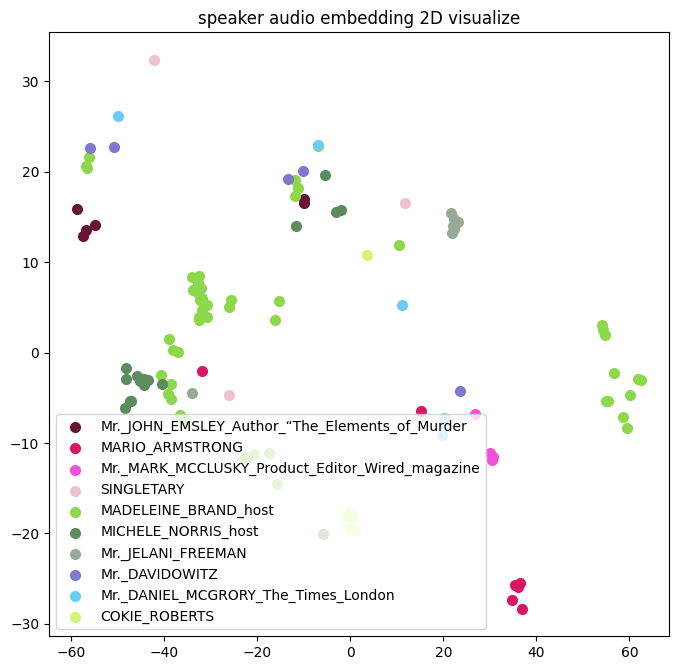

In [35]:
plot2D_by_category(embs_np_2D, embs_label, num2plot=10, with_legend=True)

Skipped 81 embeddings below threshold 0.1
Total 776 of 102 category.


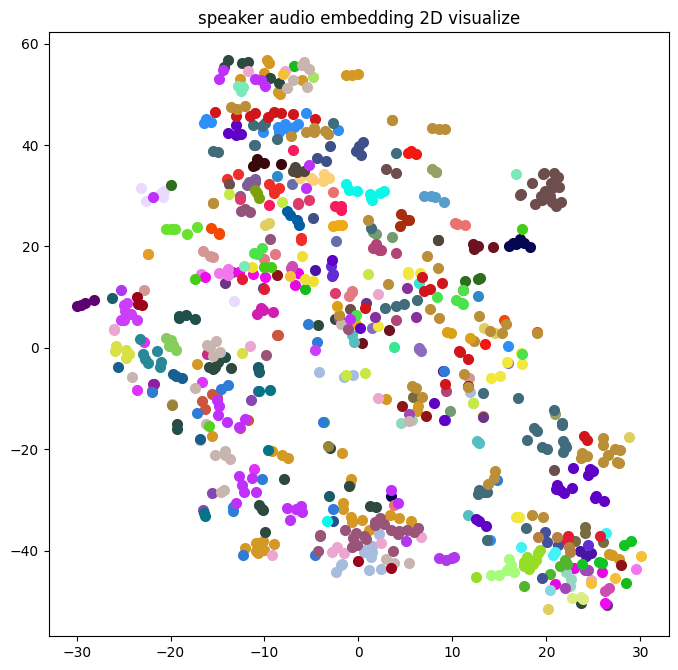

Total 776 of 102 category.
only plot 10 class


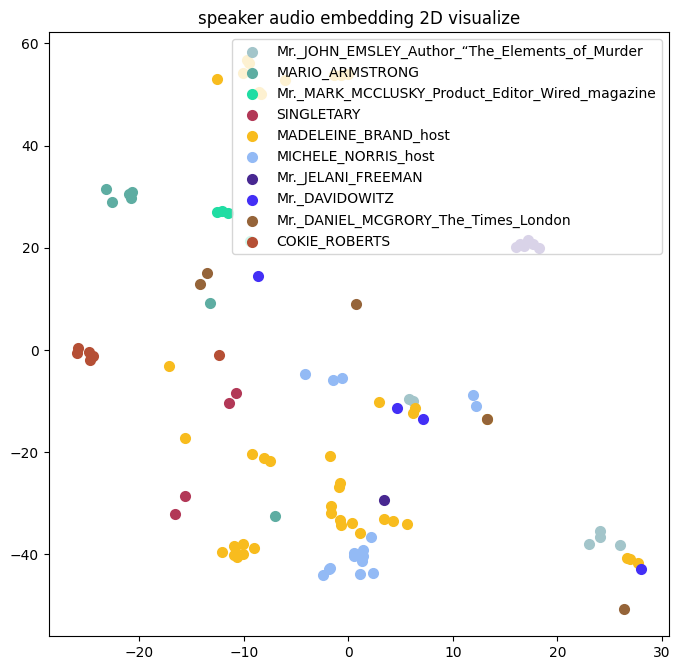

In [37]:
# skip emb under some threshold
THRESHOLD = 0.10
emb_by_spk_th = gather_emb_by_spk(filtered_rec_id, filtered_rec_inf_np_chunks, rec2chunkspks, threshold=THRESHOLD)
embs_np_th, embs_label_th = combine_emb_with_spk(emb_by_spk_th)
embs_np_th_2D = dimension_reduce_TSNE(embs_np_th)
plot2D_by_category(embs_np_th_2D, embs_label_th)
plot2D_by_category(embs_np_th_2D, embs_label_th, num2plot=10, with_legend=True)